In [1]:
from data.dataset import REFLACXWithClinicalDataset
from model.xami import  XAMIMultiCocatModal

from utils.gradcam import get_df_label_pred_img_input_loss, show_gradCAMpp_result

import torch
import os
import pandas as pd
from utils.train import get_aus_loss
import matplotlib.pylab as plt
import pandas as pd
from utils.plot import relabel_ellipse_df, get_ellipses_patch
from utils.transform import TransformFuncs
from copy import copy
from tqdm.notebook import trange
import PIL
from data.data_loader import MIMICDataloader
from eye_tracking.plot import draw_fixations, draw_scanpath, draw_heatmap, draw_raw, get_fixations_dict_from_reflacx_eye_tracking

In [2]:
pd.options.mode.chained_assignment = None
# plt.ioff()

In [3]:
# checking if the GPU is available
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"Will be using {device}")

Will be using cuda


In [4]:
# load the dataset
reflacx_dataset = REFLACXWithClinicalDataset(image_size=256)

Positive Loss weight:
[0.768546   0.78635013 0.7937685  0.8338279  0.87388724]
Negative Loss weight:
[0.231454   0.21364985 0.20623146 0.1661721  0.12611276]
Random Loss:
0.21026036153991162


In [5]:
# model_name = 'test_0_8162_epoch300_WithoutClincal_dim32_2022-02-07 21_43_31_353207'

model_name = 'test_0_8260__epoch300_WithClincal_dim32_2022-02-08 10_03_56_953198'

In [6]:
# get the trained model
xami_mutlimodal = XAMIMultiCocatModal(
    reflacx_dataset,
    device,
    use_clinical=True,
    model_dim=32, # was 64
    embeding_dim=64,
    dropout=.2,  # increase the dropout rate did improve the regularization.
    pretrained=True
)
xami_mutlimodal.load_state_dict(torch.load(os.path.join('saved_models', model_name ), map_location=device))

xami_mutlimodal = xami_mutlimodal.to(device)
xami_mutlimodal.eval()


XAMIMultiCocatModal(
  (image_net): ImageDenseNet(
    (model_ft): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer

In [7]:
loss_fn = get_aus_loss(reflacx_dataset)

In [8]:
saving_folder = f'{model_name}_result'
os.makedirs(saving_folder, exist_ok=True)

In [9]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"
mimic_dataloader = MIMICDataloader(XAMI_MIMIC_PATH)

In [10]:
model_input_image_size = reflacx_dataset.image_size
transform_fun = TransformFuncs(image_size=model_input_image_size)


In [11]:
i = list(reflacx_dataset.df.index).index(reflacx_dataset.df[reflacx_dataset.df['dicom_id'].eq("ec72dd86-36c802f0-20a909ca-8cbcc950-58733cd5")].index[0])

In [12]:
df, labels_df, pred_df, img, loss, model_input = get_df_label_pred_img_input_loss(
        xami_mutlimodal, loss_fn, reflacx_dataset, i, device)

In [13]:
image_size_x = df.iloc[0]['image_size_x']
image_size_y = df.iloc[0]['image_size_y']

image_path = df.iloc[0]['image_path']
subject_id = df.iloc[0]['subject_id']
reflacx_id = df.iloc[0]['id']


In [14]:
ellipse_df = pd.read_csv(df['anomaly_location_ellipses_path'].iloc[0])
relabeled_ellipse_df = relabel_ellipse_df(ellipse_df)

In [15]:
eye_tracking_path = mimic_dataloader.get_reflacx_eye_tracking_path(
        subject_id, reflacx_id)

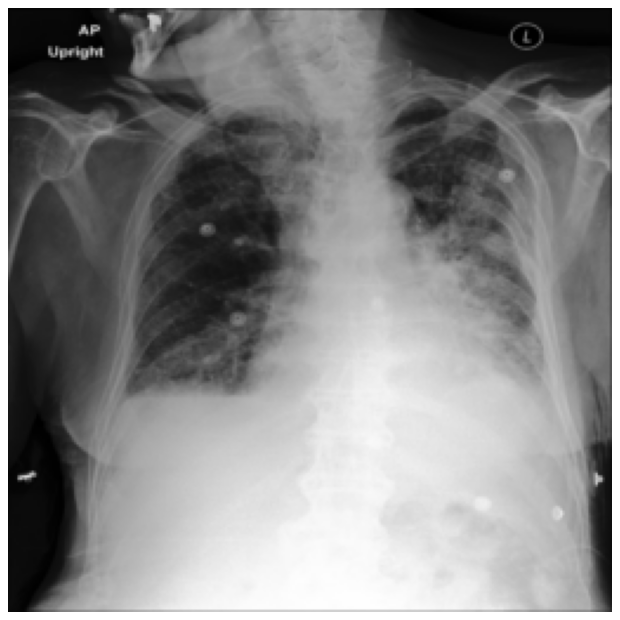

In [25]:
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=80, sharex=True)
ax.set_axis_off()
ax.imshow(transform_fun.display_transform(img))
fig.savefig("test.png", bbox_inches='tight', pad_inches = 0)

In [68]:
from matplotlib.patches import Ellipse

def get_ellipses_patch(relabeled_ellipse_df, d, image_size_x, image_size_y, model_input_image_size, color_code_map):
    ellipses = []

    for _, instance in relabeled_ellipse_df[relabeled_ellipse_df[d]].iterrows():
        center_x = (instance['xmin'] + instance['xmax']) / 2
        center_y = (instance['ymin'] + instance['ymax']) / 2
        width = abs(instance['xmax'] - instance['xmin'])
        height = abs(instance['ymax'] - instance['ymin'])

        # x_ratio = 1
        # y_ratio = 1
        x_ratio = model_input_image_size / image_size_x
        y_ratio = model_input_image_size / image_size_y

        ellipses.append(Ellipse((center_x * x_ratio, center_y * y_ratio), width=width*x_ratio, height=height*y_ratio, edgecolor=color_code_map[d],facecolor="none", linewidth=2))

    return ellipses

In [69]:
color_code_map = {
    'Enlarged cardiac silhouette': 'yellow',
    'Atelectasis': 'red',
    'Pleural abnormality': 'orange',
    'Consolidation': 'lightgreen',
    'Pulmonary edema': 'dodgerblue',
}


In [70]:
## try to plot on the original image
all_ellipses = []


for d in reflacx_dataset.labels_cols:
    all_ellipses.extend(get_ellipses_patch(
                relabeled_ellipse_df, d, image_size_x, image_size_y, model_input_image_size, color_code_map))

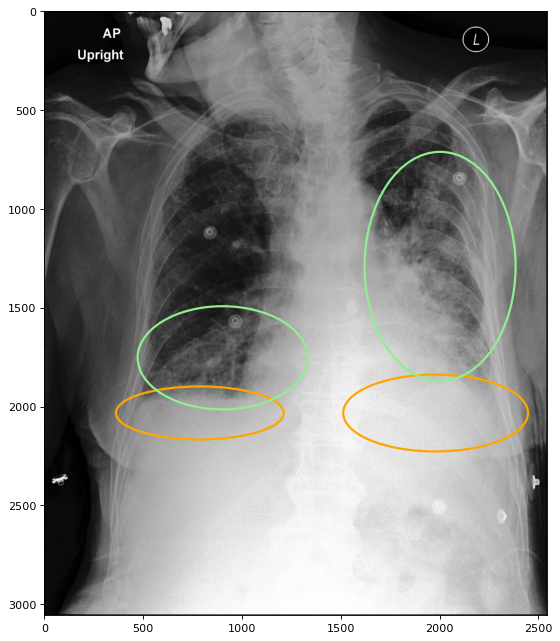

In [66]:
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=80, sharex=True)
ax.imshow(img)

for e in all_ellipses:
    ax.add_patch(copy(e))

In [ ]:
        gradcam_img = show_gradCAMpp_result(
            reflacx_dataset, xami_mutlimodal, d, img, model_input, use_full_features=True)

In [42]:
d = 'Consolidation'

In [43]:
ellipes = get_ellipses_patch(
            relabeled_ellipse_df, d, image_size_x, image_size_y, model_input_image_size)

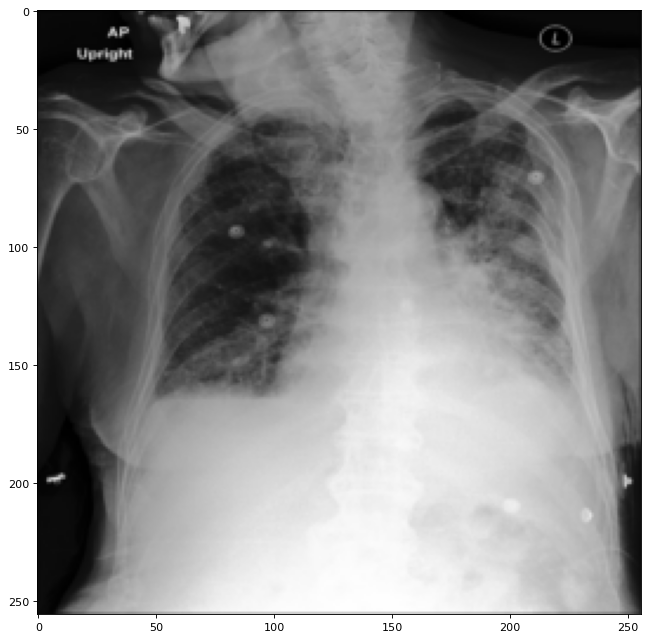

In [44]:
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=80, sharex=True)
ax.imshow(transform_fun.display_transform(img))

for e in ellipes:
    ax.add_patch(copy(e))

In [47]:
relabeled_ellipse_df['Enlarged cardiac silhouette']

0    False
1    False
2    False
3    False
4    False
Name: Enlarged cardiac silhouette, dtype: bool

In [18]:
reflacx_dataset.labels_cols

['Enlarged cardiac silhouette',
 'Atelectasis',
 'Pleural abnormality',
 'Consolidation',
 'Pulmonary edema']

In [67]:
ellipse_df

,xmin,ymin,xmax,ymax,certainty,Abnormal mediastinal contour,Acute fracture,Atelectasis,Consolidation,Enlarged cardiac silhouette,...,Groundglass opacity,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Other,Pleural abnormality,Pneumothorax,Pulmonary edema,Support devices
0,2087,929,2262,1233,5.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1620,711,2384,1870,4.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,472,1492,1331,2014,4.0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,362,1898,1211,2166,4.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,1512,1838,2447,2227,4.0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [37]:
relabeled_ellipse_df

,xmin,ymin,xmax,ymax,certainty,Airway wall thickening,Atelectasis,Consolidation,Enlarged cardiac silhouette,Fibrosis,...,Support devices,Wide mediastinum,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality
0,2087,929,2262,1233,5.0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,1620,711,2384,1870,4.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,472,1492,1331,2014,4.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,362,1898,1211,2166,4.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1512,1838,2447,2227,4.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
